In [209]:
# import dependencies
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [210]:
#load train dataset. Had to use sample of train dataset because unable to use full data(huge file - 4gb)
filename = 'train.csv'
n = sum(1 for line in open(filename)) - 1
s = 150000
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip)

In [211]:
#load destination dataset
dest = pd.read_csv('destinations.csv')

### Exploratory Data Analysis

In [212]:
#description of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  150000 non-null  object 
 1   site_name                  150000 non-null  int64  
 2   posa_continent             150000 non-null  int64  
 3   user_location_country      150000 non-null  int64  
 4   user_location_region       150000 non-null  int64  
 5   user_location_city         150000 non-null  int64  
 6   orig_destination_distance  96146 non-null   float64
 7   user_id                    150000 non-null  int64  
 8   is_mobile                  150000 non-null  int64  
 9   is_package                 150000 non-null  int64  
 10  channel                    150000 non-null  int64  
 11  srch_ci                    149795 non-null  object 
 12  srch_co                    149795 non-null  object 
 13  srch_adults_cnt            15

<Figure size 864x1008 with 0 Axes>

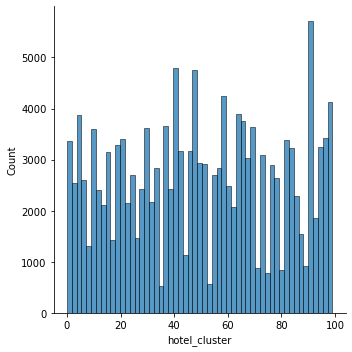

In [213]:
#hotel cluster histogram using seaborn
plt.figure(figsize=(12,14))
sns.displot(df['hotel_cluster'])

In [214]:
# Create a pivot table to see the most popular clusters
hotel_cluster_ranking = df['hotel_cluster'].value_counts()
#display 5 hostel cluster ranking based on highest count
hotel_cluster_ranking.head()

91    4087
41    3139
48    3052
64    2754
65    2679
Name: hotel_cluster, dtype: int64

In [215]:
# correlation between hotel cluster and other features
df.corr()['hotel_cluster'].sort_values()

srch_destination_type_id    -0.033226
hotel_country               -0.026654
site_name                   -0.022235
is_booking                  -0.020676
srch_destination_id         -0.013103
hotel_continent             -0.012978
user_location_country       -0.008520
srch_rm_cnt                 -0.007328
user_id                      0.000016
user_location_city           0.000098
channel                      0.000816
cnt                          0.002462
orig_destination_distance    0.008999
is_mobile                    0.011266
posa_continent               0.012285
user_location_region         0.012415
srch_adults_cnt              0.013831
srch_children_cnt            0.019118
hotel_market                 0.038189
is_package                   0.039491
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

In [216]:
#merge random sampled train dataset with destination dataset on unique id srch_destination_id
df = df.merge(dest, how= 'left', on ='srch_destination_id')

In [217]:
#drop unnecessary columns, columns which are not useful in analysis and prediction.
#We are to predict which “hotel cluster” the user is likely to book, given his (or her) search details.Not all columns are adequate.
df = df.drop(['date_time','site_name', 'user_id','srch_ci', 'srch_co'], axis=1)

In [218]:
#display columns
df.head()

,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2,3,64,12576,NaN,0,0,2,2,0,...,-2.236230,-2.236143,-2.237420,-2.237569,-2.237569,-2.235488,-2.236742,-2.237569,-2.237569,-2.236540
1,3,66,189,6881,NaN,0,0,9,1,0,...,-2.183527,-2.203410,-2.203410,-2.203410,-2.203410,-2.200032,-2.203410,-2.203410,-2.203410,-2.203410
2,1,46,171,19639,305.0827,0,1,5,2,0,...,-2.278301,-2.282803,-2.283783,-2.283783,-2.283783,-2.279514,-2.283783,-2.283783,-2.283783,-2.276540
3,2,3,64,3169,NaN,0,0,5,1,0,...,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115,-2.193115
4,3,66,315,6085,NaN,1,1,2,2,0,...,-2.244003,-2.257657,-2.216861,-2.288345,-2.283803,-2.220846,-2.288345,-2.282501,-2.288345,-2.288345


In [219]:
# Groupby search, country and market to help determine cluster
relevant_hotel_info = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(relevant_hotel_info).groupby(level=[0,1,2,3]).sum()
#agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               0      1
                                               58               1      1
                                               61               0      1
                                               82               1      1
8                   50            416          7                0      1

In [220]:
## Create sum and count column in the groupby table
agg['sum_and_count'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,4,7,246,22,0.0,0.25,0.065217
1,4,7,246,58,0.5,0.25,0.434783
2,4,7,246,61,0.0,0.25,0.065217
3,4,7,246,82,0.5,0.25,0.434783
4,8,50,416,7,NaN,0.20,0.200000


In [221]:
#create pivot table
pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_count').reset_index()
pivot.shape

(11395, 103)

In [222]:
#merge train,destination dataset with pivot table
df = pd.merge(df, pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
#fill na with 0
df.fillna(0, inplace=True)
#check shape of dataframe
df.shape

(150000, 268)

In [223]:
# Only retain booking transaction. 0 is click on website vs 1 is for booking hotel.
df = df[df['is_booking'] == 1]

In [224]:
#Setting predictor variable,the variable that helps predict the value of the output variable.
X = df.drop(['hotel_cluster'] , axis=1)
#Setting target variable,the variable that we want to predict
y = df['hotel_cluster'] 

In [225]:
# Divide into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [226]:
# Create Gaussian Naive Bayes classifier
gnb = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
# Fit the classifier to the data
gnb.fit(X_train, y_train)
# Check the accuracy
gnb.score(X_test, y_test)

0.13184245660881175

In [227]:
# Random Forest Classifier
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=260,max_depth=8,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.2459551017055114

In [228]:
# Create KNN classifier
knn = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=3))
# Fit the classifier to the data
knn.fit(X_train,y_train)
# Check the accuracy
knn.score(X_test, y_test)

0.25634178905206945

In [229]:
# K-Nearest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=6))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.2909361724642544

#### Based on above model, highest accuracy is from  K-Nearest Neighbor Classifier and lowest is from Gaussian Naive Bayes.

In [230]:
# Multi-Class Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, X, y, cv=8))

0.31247012271093144